In [27]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.linalg import block_diag

from timeit import default_timer
from Solver import *
from functools import partial

import torch

import sys
sys.path.append('../Utility')
from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
import PlotDefault
import NeuralNet
import KalmanInversion




In [31]:
betas = [1, 2, 3]

phy_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, xx, force = load_data(betas = [1, 2, 3])

In [32]:
# Visualize data

Text(0.5, 0.98, 'bottom layer')

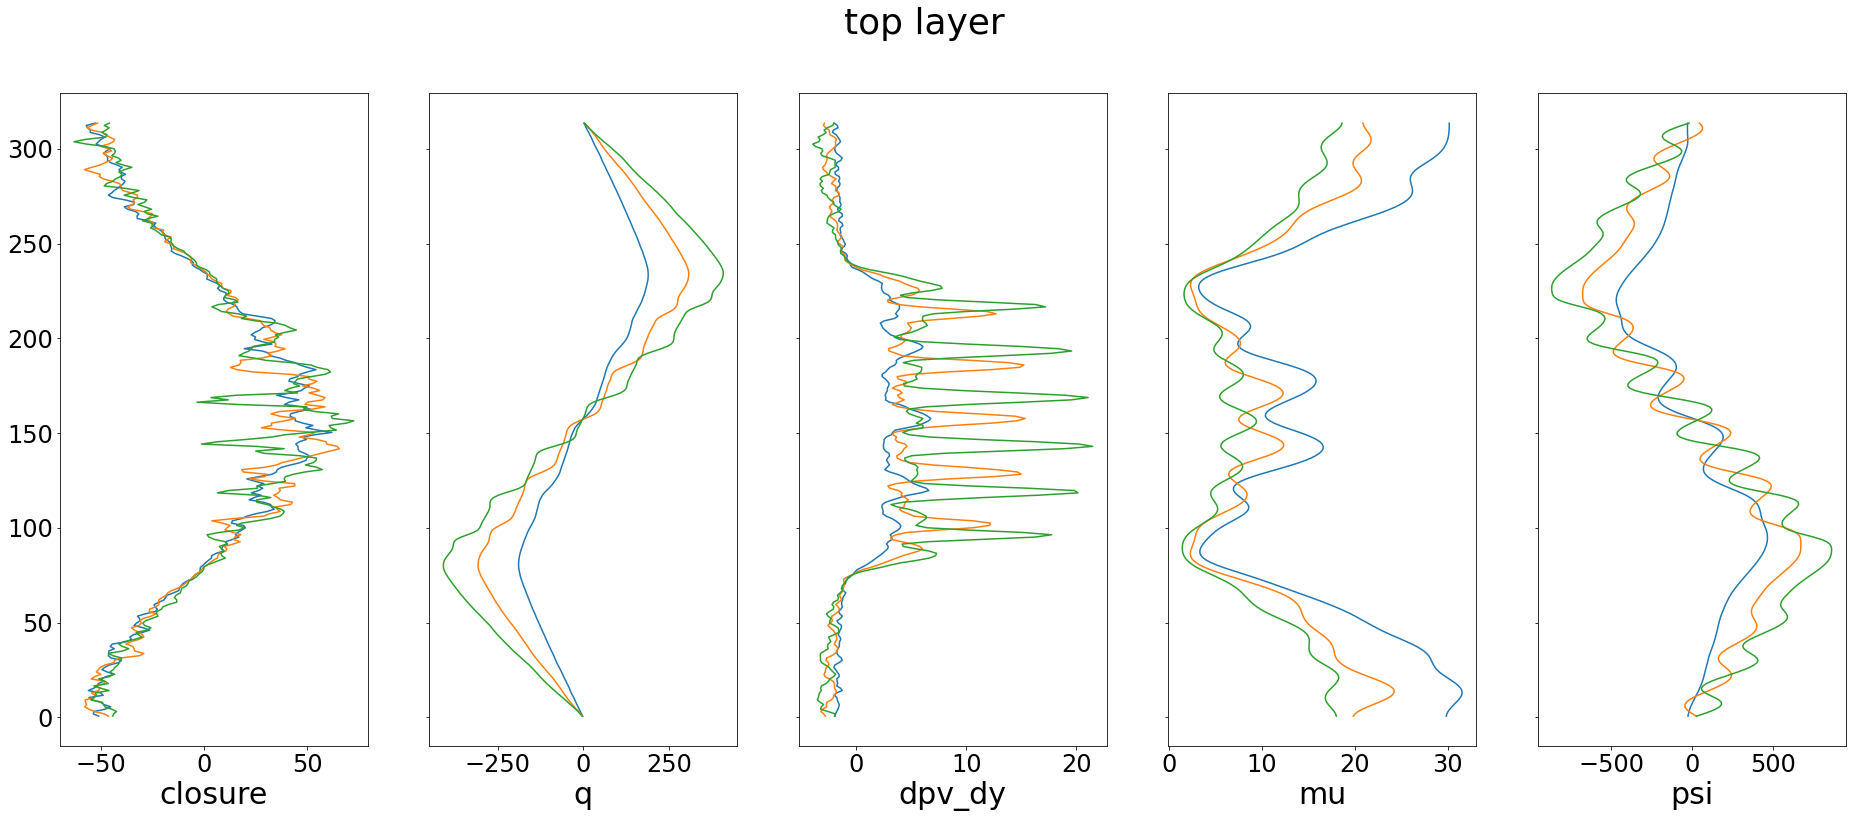

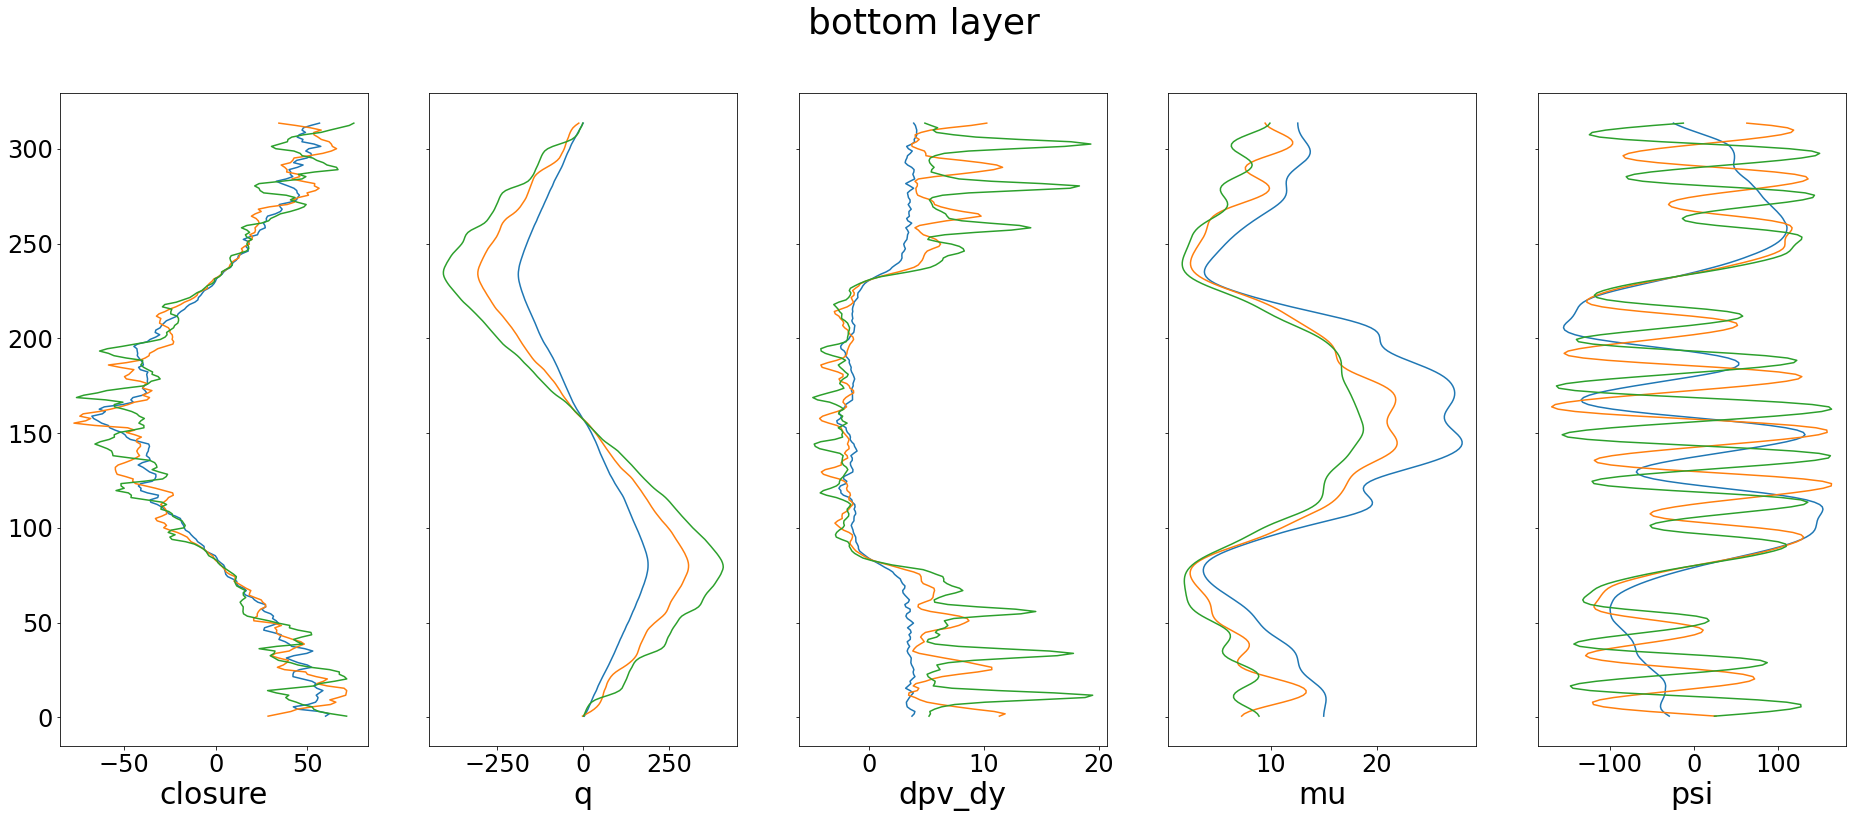

In [33]:
N_data = len(betas)
layer = 0
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("top layer")

layer = 1
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,layer, :], yy)
    ax[1].plot(q_mean[i,layer, :], yy)
    ax[2].plot(dpv_mean[i,layer, :], yy)
    ax[3].plot(mu_mean[i,layer, :], yy)
    ax[4].plot(psi_mean[i,layer, :], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dpv_dy")
    ax[3].set_xlabel("mu")
    ax[4].set_xlabel("psi")
fig.suptitle("bottom layer")

In [34]:
# Training Loss : || d(D dq/dx)/dx + f(x)|| on the quadratic function

In [41]:
def loss_aug(s_param, params):
    xx, q = s_param.xx, s_param.q
    dx = xx[1] - xx[0]
    ind, outd, width = s_param.ind, s_param.outd, s_param.width
    activation, initializer, outputlayer = s_param.activation, s_param.initializer, s_param.outputlayer
    
    N_data, _, Nx = q.shape
    # does not include top and bottom nodes
    res = np.zeros((N_data, 2, Nx))
    
    
    net =  NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer,  params)
    nn_model = partial(NeuralNet.nn_viscosity, net=net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    psi = np.zeros_like(q)
    for i in range(N_data):
        beta1 = beta2 = beta = s_param.phy_params[i].beta
        F1, F2 = s_param.phy_params[i].F1, s_param.phy_params[i].F2
        psi[i, :, :] = psi_fft_sol(q[i, :, :], F1, F2, dx)
        nummodel_fft(nn_model, beta1, beta2,  q[i, :, :], psi[i, :, :], xx, res[i, :, :])
        
        
    return np.hstack((-np.reshape(res, -1), params))


In [42]:
class QGParam:
    def __init__(self, phy_params, xx, q, N_y, ind, outd, layers, width, activation, initializer, outputlayer):
        self.theta_names = ["hyperparameters"]
        self.xx = xx
        self.q  = q
        self.ind  = ind
        self.outd = outd
        self.width = width
        self.activation = activation
        self.initializer = initializer
        self.outputlayer = outputlayer
        
        self.phy_params = phy_params
        
        
        N_theta = ind*width + (layers - 2)*width**2 + width*outd + (layers - 1)*width + outd
        self.N_theta = N_theta
        
        
        self.N_y = N_y + N_theta 

# Start UKI

In [44]:
y = np.tile(force, (len(betas),1,1))
Sigma_eta = np.fabs(y)
y = y.flatten()
for i in range(N_data):
    Sigma_eta[i, :, :] = np.mean(Sigma_eta[i, :, :])
Sigma_eta = np.diag(np.reshape((Sigma_eta*0.01)**2, -1))


N_y = len(y)
s_param = QGParam(phy_params, xx, q_mean, N_y,  ind, outd, layers, width, activation, initializer, outputlayer)


N_theta = s_param.N_theta


theta0_mean_init = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer).get_params()
# theta0_mean_init = torch.load("visc.model").get_params()
theta0_mean = np.zeros(N_theta)

theta0_cov = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov, 100.0**2)  
theta0_cov_init = np.zeros((N_theta, N_theta))
np.fill_diagonal(theta0_cov_init, 0.1**2)  


y_aug = np.hstack((y, theta0_mean))
Sigma_eta_aug = block_diag(Sigma_eta, theta0_cov)


alpha_reg = 1.0
update_freq = 1
N_iter = 10
gamma = 1.0


save_folder = "indirect_NN_res"
uki_obj = KalmanInversion.UKI_Run(s_param, loss_aug, 
    theta0_mean, theta0_mean_init, 
    theta0_cov,  theta0_cov_init, 
    y_aug, Sigma_eta_aug,
    alpha_reg,
    gamma,
    update_freq, 
    N_iter,
    save_folder = save_folder)

ukiobj.gamma :  1.0
optimization error at iter  0  =  15381331.606029676
data-misfit :  15381331.332990192 reg :  0.2730394829911232
Frobenius norm of the covariance at iter  0  =  6.4031242374328485
ukiobj.gamma :  0.5
optimization error at iter  1  =  56171190.41525902
data-misfit :  56171190.149624124 reg :  0.26563488770504456
Frobenius norm of the covariance at iter  1  =  8.516956806689665
ukiobj.gamma :  0.5
optimization error at iter  2  =  11896701.189580023
data-misfit :  11896700.894737685 reg :  0.29484233857717257
Frobenius norm of the covariance at iter  2  =  9.29688648462898
ukiobj.gamma :  0.5
optimization error at iter  3  =  9498388.031882633
data-misfit :  9498387.72169963 reg :  0.3101829998188305
Frobenius norm of the covariance at iter  3  =  0.9250196567362456
ukiobj.gamma :  0.5
optimization error at iter  4  =  9445069.569113862
data-misfit :  9445069.279100223 reg :  0.29001363870159186
Frobenius norm of the covariance at iter  4  =  0.28775660306366607
ukiob